# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment
<br>
by Chukwuemeka Ezumezu

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

#####**Note: This project is still a work in progress. Research from YouTube, Kaggle, and Stackoverflow was helpful during the project.**

## **Understanding the assessment problem**:
Instead of manually outlining and segmenting the tumor and the stomach this will lead to delayed treatment of patients. A deep learning model is employed to automatically segment the tumor and stomach region to help the urologist know the region where a high dose of radiation will be applied to the tumor and the region for the low-level radiation to be applied while making sure the stomach is entirely avoided.

## **Data Understanding**:
### **Data Description**:
The goal here is to segment organ cells in images. The training annotations are provided as RLE-encoded masks, and the images are in 16-bit grayscale PNG format.

The goal of this project is to be able to generalize to both partially and wholly unseen cases, which is always a good practice.
Each case (whereby each case represents a single patient) in this project is represented by multiple sets of scan slices of the patient (each set is identified by the day the scan took place - i.e collections of daily scans of the patient). Some cases are split by time (early days are in train, later days are in test) - i.e splitting patients scanned images and placing the early days in the train set and later days in test set while some cases are split by case - the entirety of the case is in train or test. i.e some patients scanned images are in the train set while some are in the test set.

Note that, in the case of this project/competition, the test set is entirely unseen. It is roughly 50 cases, with varying days and slices, as seen in the training set.

### How the entirely hidden test set work:
The test set in this project/competition is only available when the code is submitted. The sample_submission.csv is an empty placeholder that shows the required submission format; modeling, cross-validation, etc., will be performed using the training set, and code will be written to process a non-empty sample submission. It will contain rows with id, class, and predicted columns.
When the notebook is submitted, the code will be run against the non-hidden test set, which has the same folder format (<case>/<case_day>/<scans>) as the training data.

### Files:
* train.csv - IDs and masks for all training objects.
* sample_submission.csv - a sample submission file in the correct format
* train - a folder of case/day folders, each containing slice images for a particular case on a given day.

Note that the image filenames include 4 numbers (ex. 276_276_1.63_1.63.png). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

Physical pixel thickness in superior-inferior direction is 3mm.

### Columns:
* id - unique identifier for object
* class - the predicted class for the object
* EncodedPixels - RLE-encoded pixels for the identified object

## **Data Preparation**

Changing to the working directory (for use in Google Colab)

In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# changing to the working directory (for use in Colab)
%cd '/content/drive/MyDrive/Chekkit/Assessment/UW-Madison GI Tract Image Segmentation'

/content/drive/MyDrive/Chekkit/Assessment/UW-Madison GI Tract Image Segmentation


Importing all the necessary libraries

In [5]:
# importing all the necessary library
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
import gc
from tqdm import tqdm
from datetime import datetime
from typing import Optional
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras.models import load_model, save_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.layers import Input

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from config import * 
import os

from utils import *
#from train import *
from datagen import *

### Downloading the dataset from Kaggle to Google Colab

Below is for downloading of dataset from Kaggle to Google Colab and unziping it into the dataset folder for the project.

In [ ]:
# change to the root directory
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


Downloading the the dataset from Kaggle to Google Colab (Google drive) through Kaggle API

In [ ]:
# downloading the the dataset

from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
# %cd '/content/drive/MyDrive/'
! mkdir kaggle
! cp kaggle.json kaggle/
! chmod 600 kaggle/kaggle.json

# You can check if everything's okay by running this command.
! kaggle datasets list

# credit: https://stackoverflow.com/questions/62673074/download-file-from-kaggle-to-google-colab

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘kaggle’: File exists
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
%cd kaggle/

# print working directory
!pwd

/content/drive/MyDrive/kaggle
/content/drive/MyDrive/kaggle


Downloading the Kaggle dataset by copying the API of the dataset, downloading, then unzipping and deleting the zipped file

In [ ]:
# download the Kaggle dataset by copying the api of the dataset
# then unzip and delete the zipped file
! kaggle competitions download -c uw-madison-gi-tract-image-segmentation

# List of items on the working directory
%ls

# credit: https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07

100% 2.29G/2.30G [00:15<00:00, 84.4MB/s]
100% 2.30G/2.30G [00:15<00:00, 156MB/s] 
kaggle.json  uw-madison-gi-tract-image-segmentation.zip


In [ ]:
# the whole changing of directory is to move the dataset from normal Kaggle download directory
# to a dataset directory for the project and then to the working directory.

# move the zipped dataset from the regular Kaggle directory to the working directory
! mv "uw-madison-gi-tract-image-segmentation.zip" "/content/drive/MyDrive/Chekkit/Assessment/input/uw-madison-gi-tract-image-segmentation"

# change the so the dataset can be unzipped
%cd '/content/drive/MyDrive/Chekkit/Assessment/input/uw-madison-gi-tract-image-segmentation'

/content/drive/MyDrive/Chekkit/Assessment/UW-Madison GI Tract Image Segmentation


In [ ]:
! unzip  uw-madison-gi-tract-image-segmentation.zip

In [ ]:
# change back to the working directory
%cd '/content/drive/MyDrive/Chekkit/Assessment/UW-Madison GI Tract Image Segmentation'

/content/drive/MyDrive/Chekkit/Assessment/UW-Madison GI Tract Image Segmentation


## **Exploratory Data Analysis (EDA) and Feature Extraction**

In [6]:
train_df_original = pd.read_csv(TRAIN_ROOT_DIR + 'train.csv')

# print the numbers rows and columns 
print(train_df_original.shape)

train_df_original.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


Pie chart of the value counts/distribution for the large_bowel, stomach, and small_bowel

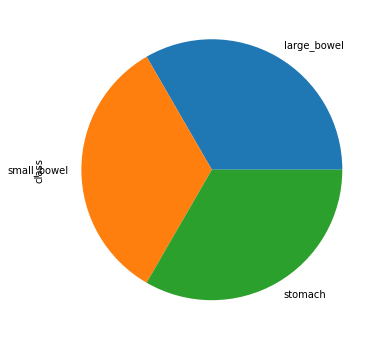

In [7]:
# pie chart of the value counts/distribution for the large_bowel, stomach, and small_bowel 
plt.figure(figsize=(14, 6))
train_df_original['class'].value_counts(normalize=True).plot.pie()

Reading in the variable, test_df, which returns an empty dataframe

In [8]:
# reading in the variable, test_df, which returns an empty dataframe
test_df = pd.read_csv(TRAIN_ROOT_DIR + 'sample_submission.csv')
test_df.head()

,id,class,predicted


Taking the first 300 rows from original train dataset and assigning them to the test_df variable

In [9]:
# taking the first 300 rows from original train dataset and
# assigning them to the test_df variable
if len(test_df) == 0:
    DEBUG=True
    # take the first 300 rows
    test_df=pd.read_csv(TRAIN_ROOT_DIR + 'train.csv').iloc[:300, :]
    test_df['segmentation'] = ''
    
    # rename the segmentation to prediction
    test_df = test_df.rename(columns={'segmentation' : 'prediction'})
else:
    DEBUG=False
    
submission = test_df.copy()
test_df.head()

,id,class,prediction
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


## **Feature Extraction**

A helper funturn was created in the helper_fun.py that created columns with 'case', 'day', 'slice'. 
The output dataframe was assigned to a train_df varible.

In [10]:
# a helper funturn was created in the helper_fun.py that created columns 
# with 'case', 'day', 'slice'. The output dataframe was assigned to a train_df varible.
train_df = df_preparation(train_df_original, subset="train")

train_df.head(10)

all_images length  38496


,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
5,case123_day20_slice_0002,stomach,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
6,case123_day20_slice_0003,large_bowel,NaN,123,20,0003,../input/uw-madison-gi-tract-image-segmentatio...,266,266
7,case123_day20_slice_0003,small_bowel,NaN,123,20,0003,../input/uw-madison-gi-tract-image-segmentatio...,266,266
8,case123_day20_slice_0003,stomach,NaN,123,20,0003,../input/uw-madison-gi-tract-image-segmentatio...,266,266
9,case123_day20_slice_0004,large_bowel,NaN,123,20,0004,../input/uw-madison-gi-tract-image-segmentatio...,266,266


Counts for the rows and columns of the test_df

In [11]:
# counts for the rows and columns of the test_df
test_df.head()
test_df.shape

(300, 3)

Creating a detailed test dataframe with the df_preparation() helper function

In [12]:
# creating a detailed test dataframe
test_df=df_preparation(test_df, subset="test", DEBUG=True)
test_df.head()

all_images length  38496


,id,class,prediction,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


### Rearrange train_df

Why rearranging train_df is needed. Because we original train.csv, each has 3 duplicated rows, which represents segmentation for 3 classes, large bowel, small bowel, and stomach. With the rearrange train_df, we extract 3 columns with the same segmentation name and assign corresponding values.

In [13]:
# extracting the 3-column value of large_bowel, small_bowel, and stomach 
# with df_rearrange_for_3_segmentation_classes() method
train_df_rearranged=df_rearrange_for_3_segmentation_classes(train_df, subset="train")
train_df_rearranged.head(100)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266,0
...,...,...,...,...,...,...,...,...,...,...,...
95,case123_day20_slice_0096,14796 1 15059 8 15073 2 15324 20 15590 22 1585...,20890 4 21155 8 21421 10 21687 11 21745 6 2195...,20596 7 20861 9 21125 12 21391 12 21656 13 219...,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0096,266,266,3
96,case123_day20_slice_0097,14792 6 15057 9 15071 7 15322 24 15588 25 1585...,20890 4 21155 7 21209 9 21421 9 21469 18 21687...,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0097,266,266,2
97,case123_day20_slice_0098,14525 7 14789 11 14807 4 15055 13 15070 9 1532...,20679 8 20891 1 20944 10 21155 6 21201 20 2142...,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0098,266,266,2
98,case123_day20_slice_0099,14524 9 14789 14 14805 5 15054 24 15264 3 1532...,20149 6 20413 9 20677 12 20941 15 21155 5 2120...,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0099,266,266,2


The next cell is to remove the mismatched data that will likely affect our model, as the mask does not align with the image. As was highlighted in the discussion forum on Kaggle.


In [14]:
# Remove misslabeled training data
train_df_rearranged = train_df_rearranged[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df['case']!=138)|(train_df['day']!=00)].reset_index(drop=True)

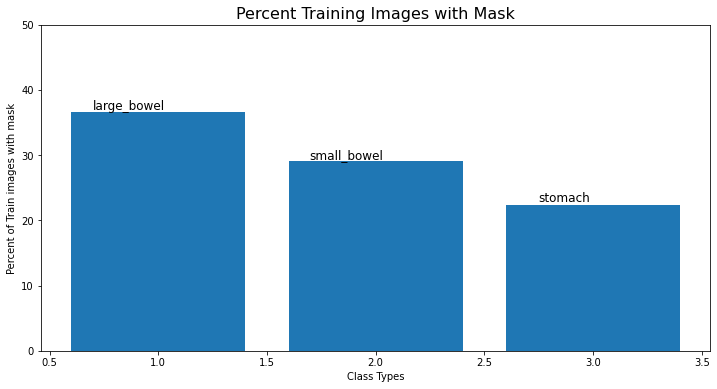

In [15]:
plot_bar(train_df_rearranged)

Plotting and masking the images with color patches for large bowel, small bowel, and stomach (plot of images of train dataset with the mask side by side).

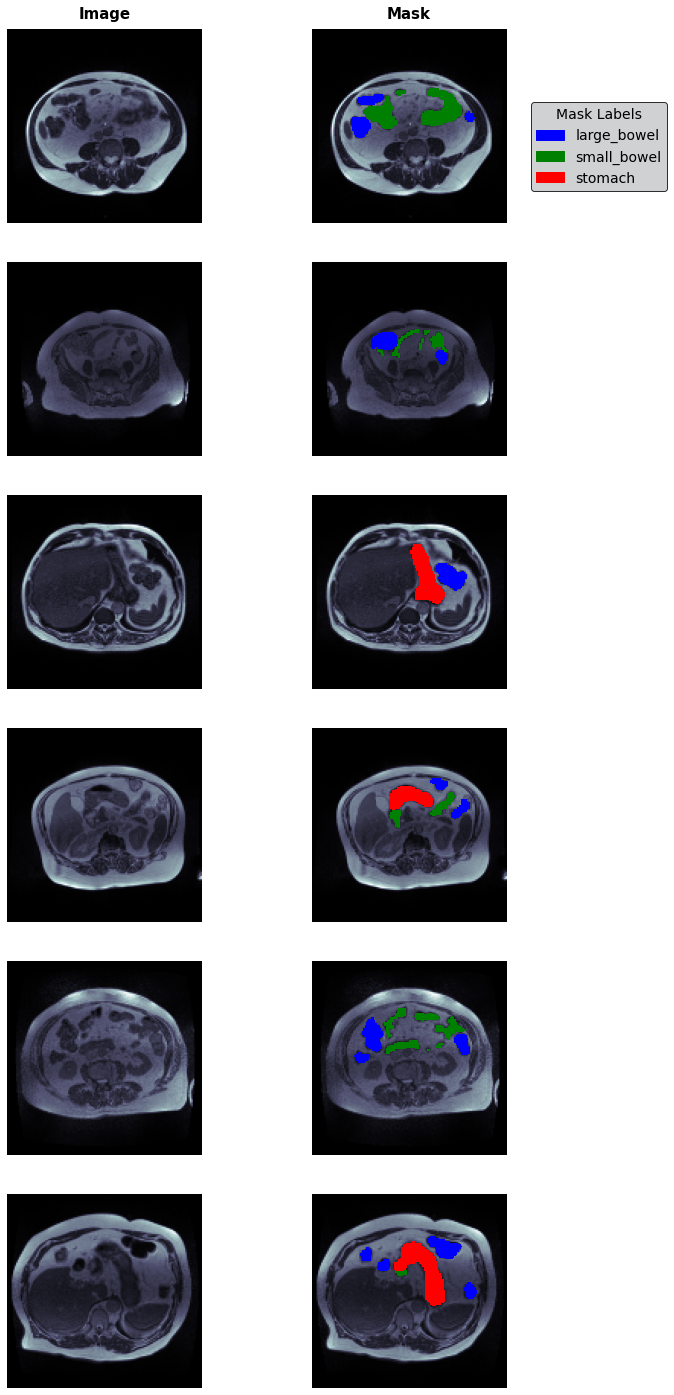

In [16]:
# plot of images of train dataset with the mask side by side
colors = ['blue','green','red']

labels = ["large_bowel", "small_bowel", "stomach"]

plot_mask_with_color_patches(train_df_rearranged, colors, labels)

### StratifiedGroupKFold Cross-Validation

StratifiedGroupKFold Cross-Validation helps with classifying a class imbalance. The imbalance of classes in the dataset will be taken handled/taken care of by stratification.

I reference to StratifiedGroupKFold Cross-Validation can be found here:
https://www.kaggle.com/code/jakubwasikowski/stratified-group-k-fold-cross-validation/notebook

In [17]:
# return different folds with the number of image taken
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(
    skf.split(
        X=train_df_rearranged,
        y=train_df_rearranged["count"],
        groups=train_df_rearranged["case"],
    ),
    1,
):
    train_df_rearranged.loc[val_idx, "fold"] = fold

train_df_rearranged["fold"] = train_df_rearranged["fold"].astype(np.uint8)

train_ids = train_df_rearranged[train_df_rearranged["fold"] != fold_selected].index
valid_ids = train_df_rearranged[train_df_rearranged["fold"] == fold_selected].index

X_train = train_df_rearranged[train_df_rearranged.index.isin(train_ids)]
X_valid = train_df_rearranged[train_df_rearranged.index.isin(valid_ids)]

train_df_rearranged.groupby("fold").size()

fold
1    7920
2    6624
3    7952
4    8624
5    7376
dtype: int64

In [18]:
train_df_rearranged.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count,fold
0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266,0,2
1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266,0,2
2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266,0,2
3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266,0,2
4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266,0,2


In [19]:
train_df_rearranged.groupby(['fold','count'])['id'].count()

fold  count
1     0        4486
      1         485
      2        2230
      3         719
2     0        3847
      1         347
      2        1876
      3         554
3     0        4604
      1         576
      2        2138
      3         634
4     0        4862
      1         734
      2        2400
      3         628
5     0        4107
      1         326
      2        2277
      3         666
Name: id, dtype: int64

In [20]:
# a check to see that the format is working properly
experiment = False
if experiment:
    X_train = X_train[X_train.case.isin(X_train.case.unique()[:5])]
    X_valid = X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]
    
print(X_train.shape)
print(X_valid.shape)

(31872, 12)
(6624, 12)


# **Modelling**

Define train_generator variable that will be passed into the model.fit()

In [21]:
# Define train_generator variable that will be passed into the model.fit()
train_generator = DataGenerator(X_train, shuffle = True)
val_generator = DataGenerator(X_valid)

### U-Net Model

install segmentation module

In [22]:
#install segmentation module
# source (https://stackoverflow.com/questions/67529314/how-to-import-segmentation-models-with-tensorflow-keras-getting-modulenotfounde/70222685#70222685)
#!pip3 install tensorflow==2.2
#!pip3 install keras==2.3.1
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.4 MB/s 


Importing segmentation models of Keras

In [23]:
# importing segmentation models of Keras
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

The model is U-Net and for the network architecture for encoder and decoder part (i.e for up-sample and down-sampling) is inceptionresnetv2.

In [24]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('inceptionresnetv2', input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights = 'imagenet' )
model.compile(optimizer = 'adam', loss=bce_dice_loss, metrics=[dice_coef, iou_coef])

219070464/219055592 [==============================] - 2s 0us/step


### Model Training

Defining the checkpoint and early stopping conditions

In [25]:
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

early_stopping = EarlyStopping(
    patience = 5,
    min_delta = 0.0001,
    restore_best_weights= True
)

Training the model

**There some improvement after 10 epochs, more training will improve the performance of the model**

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCH
)

Epoch 1/10
1992/1992 [==============================] - ETA: 0s - loss: 0.2628 - dice_coef: 1.5346 - iou_coef: 0.3389
Epoch 1: val_loss improved from inf to 0.34884, saving model to UNET_model
INFO:tensorflow:Assets written to: UNET_model/assets
1992/1992 [==============================] - 3500s 2s/step - loss: 0.2628 - dice_coef: 1.5346 - iou_coef: 0.3389 - val_loss: 0.3488 - val_dice_coef: 1.3420 - val_iou_coef: 0.3564
Epoch 2/10
1992/1992 [==============================] - ETA: 0s - loss: 0.1479 - dice_coef: 1.7316 - iou_coef: 0.6448
Epoch 2: val_loss did not improve from 0.34884
1992/1992 [==============================] - 531s 266ms/step - loss: 0.1479 - dice_coef: 1.7316 - iou_coef: 0.6448 - val_loss: 0.3675 - val_dice_coef: 1.3326 - val_iou_coef: 0.5523
Epoch 3/10
1992/1992 [==============================] - ETA: 0s - loss: 0.1257 - dice_coef: 1.7722 - iou_coef: 0.7028
Epoch 3: val_loss improved from 0.34884 to 0.31949, saving model to UNET_model
INFO:tensorflow:Assets written t

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history_df")

From the graph below, the Loss is still decreasing after 10 epoches. More training will improve the performance of the model. Similary, the Dice Loss and IoU Loss are improving continiously over the epoches.

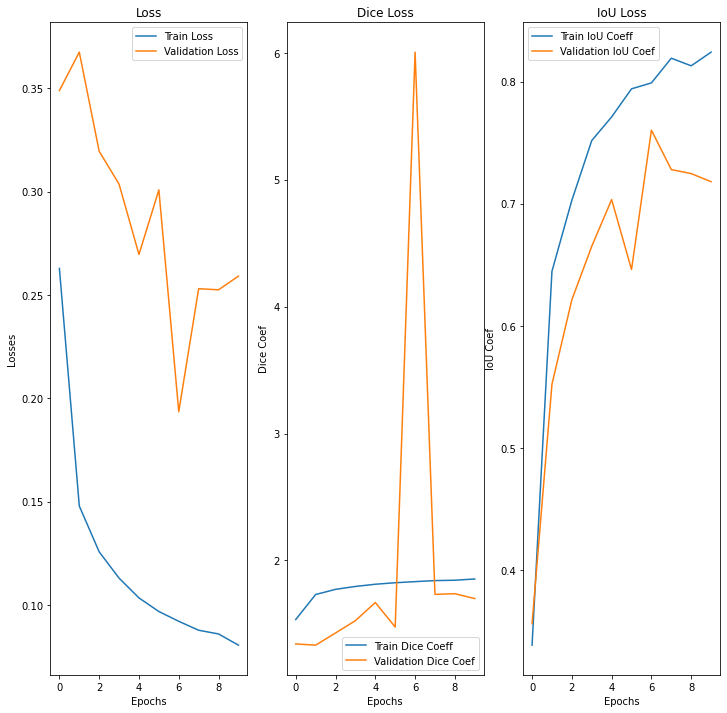

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.plot(range(history.epoch[-1] + 1), history.history['loss'], label='Train Loss' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_loss'], label='Validation Loss' )
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(history.epoch[-1] + 1), history.history['dice_coef'], label='Train Dice Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_dice_coef'], label='Validation Dice Coef' )
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(history.epoch[-1] + 1), history.history['iou_coef'], label='Train IoU Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_iou_coef'], label='Validation IoU Coef' )
plt.title('IoU Loss')
plt.xlabel('Epochs')
plt.ylabel('IoU Coef')
plt.legend()
plt.show()

# **Validation**

### Evaluation on Test Data

Load the already trained model from UNET_model folder

In [26]:
# Loading the already trained model
def f1(y_true, y_pred):
    metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)
    metric.update_state(y_true, y_pred)
    return metric.result()

#model = tf.keras.models.load_model('UNET_model', compile=False, custom_objects={'f1': f1})
model = load_model('UNET_model', compile=False, custom_objects={'f1': f1})

First is to get test dataset batches from DataGenerator and then apply model.predict for the prediction.

In [27]:
pred_batches = DataGenerator(X_valid.iloc[500:508, :], batch_size =1, subset = 'train', shuffle = True)

preds = model.predict(pred_batches, verbose = 1)

8/8 [==============================] - 16s 186ms/step


**The images below represents the original image, mask of the original image, and the predicted mask (the model needs more training for a better result). From the first image, mask and predict, we cn see that the position of the stomach is partilly identified**

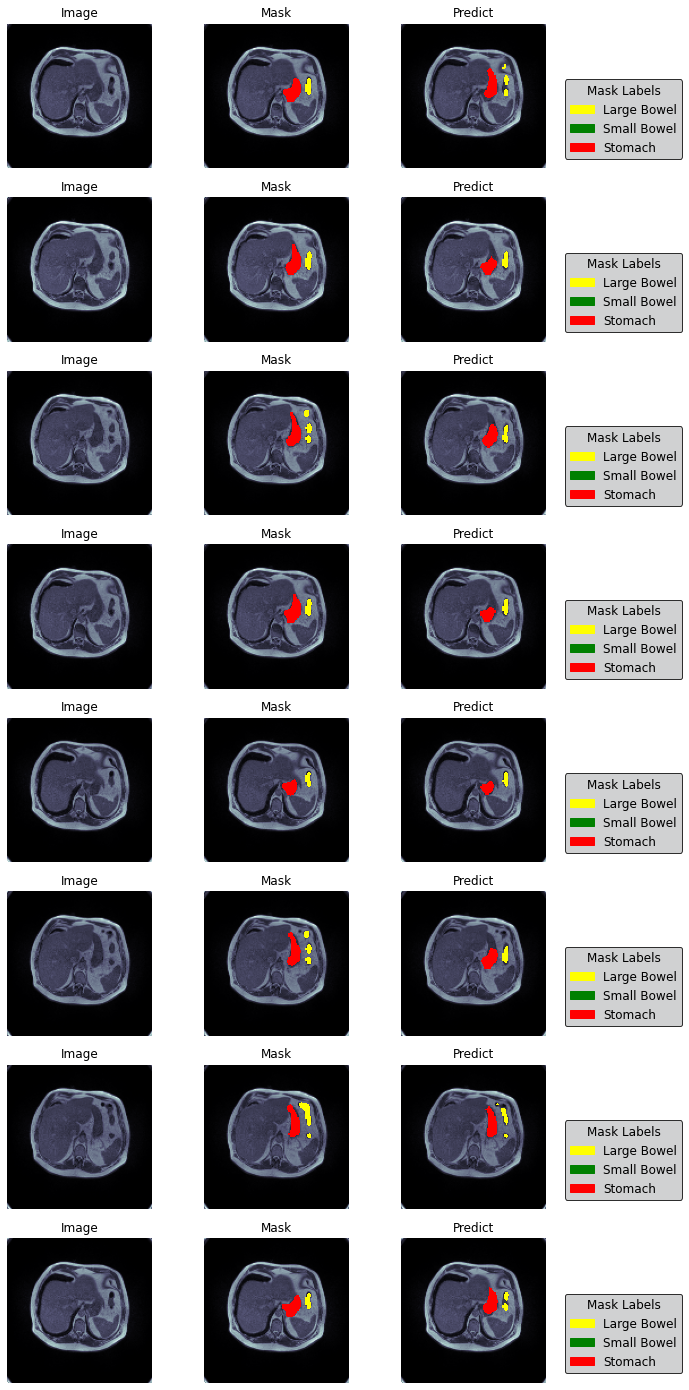

In [28]:
Threshold = 0.5

fig = plt.figure(figsize =(10, 25))
gs = gridspec.GridSpec(nrows = 8, ncols = 3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]

patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img = images[0, :, :, 0]
    
    mask1 = mask[0, :, :, 0]
    mask2 = mask[0, :, :, 1]
    mask3 = mask[0, :, :, 2]
    
    prediction_i = preds[i]
    predict1 = prediction_i[:, :, 0]
    predict2 = prediction_i[:, :, 1]
    predict3 = prediction_i[:, :, 2]
    
    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12, y=1.01)
    l0 = ax1.imshow(sample_img, cmap="bone")
    l1 = ax1.imshow(np.ma.masked_where(mask1 == False, mask1), cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2 == False, mask2), cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3 == False, mask3), cmap=cmap3, alpha=1)
    
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap="bone")
    l1 = ax2.imshow(np.ma.masked_where(predict1 == False, predict1), cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2 == False, predict2), cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3 == False, predict3), cmap=cmap3, alpha=1)
    
    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3] ]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize=12, title="Mask Labels", title_fontsize=12, edgecolor='black', facecolor='#c5c6c7' )

# **Inference/Predictions**

### Run Length Encoding (RLE) for image segmentation (help save data space and make calculation efficient)

Run-length encoding (RLE) is a form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run.

Source (Wikipedia): https://en.m.wikipedia.org/wiki/Run-length_encoding#:~:text=Run%2Dlength%20encoding%20(RLE),than%20as%20the%20original%20run.

Other reference on RLE: https://q-viper.github.io/2021/05/24/coding-run-length-encoding-in-python/

<br>
Note: For rle_encode() and rle_decode() method implementation check the helper_func.py, referring
<br>
https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode/script

### Final Prediction

The final step for the competition submittion needs the model to be run and get the prediction on the test dataset.

In [ ]:
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,128,128,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)

# **Submission/Deployment/Presentation**

### Generation of Submission Files on Test Dataset

Converting the dataframe into a CSV file, that is the requirment for the submission.

In [ ]:
submission.to_csv('submission.csv', index=False)
submission.sample(20)

### References:

* https://www.youtube.com/watch?app=desktop&v=q6E8kGbpaMI&t=2560s
* https://medium.com/mlearning-ai/brain-tumor-segmentation-using-deep-learning-models-5047984b53c0
* https://seymatas.medium.com/pytorch-image-segmentation-tutorial-for-beginners-i-88d07a6a63e4
* https://seymatas.medium.com/pytorch-image-segmentation-tutorial-for-beginners-ii-edd79a92358a
* https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/